# Привет! Тут мы анализируем русскоязычные твиты :)

#### Датасет:
https://drive.google.com/drive/folders/0BxlA8wH3PTUfV1F1UTBwVTJPd3c    
#### Задания:
1. Успешно запустить имеющийся ноутбук
2. Запустить этот же ноутбук на данных ___ttk___
3. Вместо BoW попробовать tf-idf, сравнить результаты
4. Попробовать предобученные эмбеддинги для слов:
    - скачать модель fasttext http://vectors.nlpl.eu/repository/11/181.zip
    - установить пакет gensim для использования предобученной модели
    - загрузить модель и сгенерировать эмбеддинги для каждого слова в твите + затем усреднить вектора https://github.com/RaRe-Technologies/gensim-data/issues/27
    - визуализировать результат
5. Вместо TSNE можно пробовать использовать другие методы уменьшения размерности данных: PCA, Umap, Random Projection.
6. Полученные визуализации показать преподавателю    

Если будут вопросы - обращайтесь :)

# Задание 1

## Успешно запустить имеющийся ноутбук

### I. Импортим нужные библиотеки

In [2]:
import xmltodict
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import random_projection
import umap

### II. Определяем функции с парсингом входных данных

In [175]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_bank(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

### III. Обрабатываем наши данные

In [176]:
train_filename = "SentiRuEval_2016/bank_train_2016.xml"
test_filename = "SentiRuEval_2016/banks_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

### IV. Заменяем все ссылки и юзернеймы на url и user соответственно

In [177]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [178]:
train.head()

text  answer     company  \
0                 url Взять кредит тюмень альфа банк       0    alfabank   
1                Мнение о кредитной карте втб 24 url       0         vtb   
2  «Райффайзенбанк»: Снижение ключевой ставки ЦБ ...       0  raiffeisen   
3  Современное состояние кредитного поведения в р...       0    sberbank   
4         user user Главное чтоб банки СБЕР и ВТБ!!!       1    sberbank   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [179]:
train['answer'].value_counts()

 0    7158
-1    2807
 1     760
Name: answer, dtype: int64

In [180]:
test.head()

text  answer company  \
0           #Автокредит в россельхозбанк в череповце       0    rshb   
1  RT user url #Кредитный калькулятор россельхозб...       0    rshb   
2              #Автокредит в россельхозбанк 2012 url       0    rshb   
3        RT user #Кредитные карты россельхозбанк url       0    rshb   
4      RT user #Кредиты в россельхозбанке ижевск url       0    rshb   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

### V. BoW векторайзер с 100 самыми частотными словами

In [181]:
vectorizer = CountVectorizer(max_features=100)

In [182]:
X = vectorizer.fit_transform(train['text'])

In [183]:
X.shape

(10725, 100)

### VI. Смотрим на результаты

In [184]:
decomposition = TSNE(n_components=2)

In [185]:
%%time
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 2min 39s


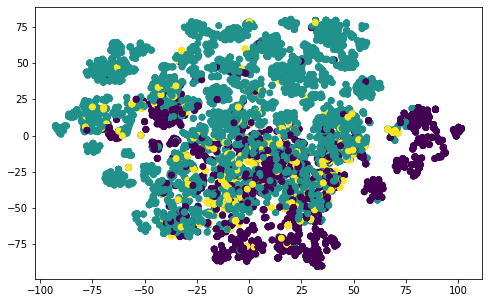

In [186]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

# Задание 2

## Запустить этот же ноутбук на данных ttk

### Определяем функции с парсингом входных данных

In [14]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_tkk(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

### Обрабатываем данные

In [15]:
train_filename = "SentiRuEval_2016/tkk_train_2016.xml"
test_filename = "SentiRuEval_2016/tkk_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

### Заменяем все ссылки и юзернеймы на url и user соответственно

In [16]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [17]:
train.head()

text  answer  company  \
0  user Максим, Вашем письмо мы получили. Наши со...       0  beeline   
1     «Мегафон» стал владельцем 50% акций «Евросети»       0  megafon   
2  RT user “user МТС Россия прислала жителям Херс...      -1      mts   
3         ВИДЕО: url Реклама со смехом МТС - Супер 0       1      mts   
4  user потому что МТС достало, а пчел ненавижу с...      -1      mts   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [18]:
train['answer'].value_counts()

 0    5213
-1    2611
 1    1385
Name: answer, dtype: int64

In [19]:
test.head()

text  answer  company  \
0  RT vzglyad: По делу о работе МТС в Узбекистане...      -1      mts   
1         RT user url #Кредитные карты мегафон банка       0  megafon   
2          #Оформить кредитную карту в банке мтс url       0      mts   
3  #Как перевести деньги с билайна на кредитную к...       0  beeline   
4  #Начальник отдела кредитного контроля оао мтс ...       0      mts   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

### BoW векторайзер с 100 самыми частотными словами

In [20]:
vectorizer = CountVectorizer(max_features=100)

In [21]:
X = vectorizer.fit_transform(train['text'])

In [22]:
X.shape

(9209, 100)

### Смотрим Результаты

In [23]:
decomposition = TSNE(n_components=2)

In [24]:
%%time
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 2min 2s


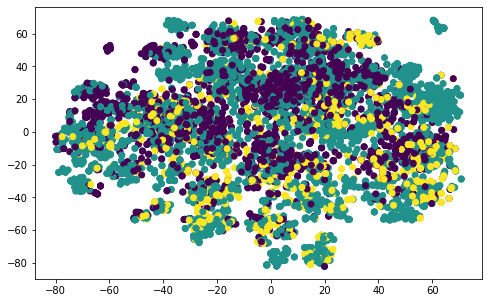

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

# Задание 3.1 на bank datasets

## Вместо BoW попробовать tf-idf, сравнить результаты

In [26]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_bank(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

In [27]:
train_filename = "SentiRuEval_2016/bank_train_2016.xml"
test_filename = "SentiRuEval_2016/banks_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

In [28]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [29]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [30]:
%%time
decomposition = TSNE(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 2min 24s


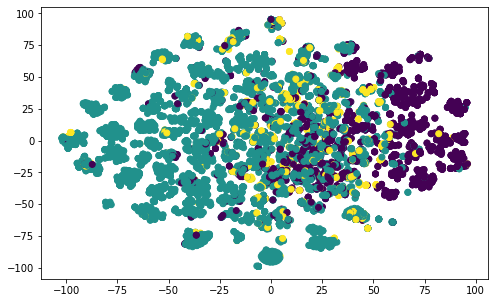

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

# Задание 3.2 на tkk datasets

## Вместо BoW попробовать tf-idf, сравнить результаты

In [3]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_tkk(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

In [4]:
train_filename = "SentiRuEval_2016/tkk_train_2016.xml"
test_filename = "SentiRuEval_2016/tkk_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

In [5]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [6]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [7]:
%%time
decomposition = TSNE(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 1min 53s


In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

# Задание 4.1 на tkk datasets

Попробовать предобученные эмбеддинги для слов:
* скачать модель fasttext http://vectors.nlpl.eu/repository/11/181.zip
* установить пакет gensim для использования предобученной модели
* загрузить модель и сгенерировать эмбеддинги для каждого слова в твите + затем усреднить вектора https://github.com/RaRe-Technologies/gensim-data/issues/27
* визуализировать результат

### tkk

In [9]:
import gensim

In [109]:
#def tag_1(word):
#    from pymystem3 import Mystem
#    m = Mystem()
#    processed = m.lemmatize(word)
#    return processed[0]

In [110]:
#def tag(word):
#    from pymystem3 import Mystem
#    m = Mystem()
#    processed = m.analyze(word)[0]
#    lemma = processed["analysis"][0]["lex"].lower().strip()
#    return lemma

In [10]:
%%time
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

ls_train = []
for line in train['text'].str.split():
    words = []
    for word in line:
        p = morph.parse(word)[0]  # делаем разбор
        words.append(p.normal_form)
    ls_train.append(words)

Wall time: 1min 48s


In [22]:
%%time
X_embedded_tkk = []
model = gensim.models.KeyedVectors.load('181/model.model')
for word in ls_train:
    X_embedded_tkk.append(model[word])

Wall time: 9min 22s


In [23]:
## Усредняем полученное
X_mean = []
for i in range(len(X_embedded_tkk)):
    words = []
    for j in X_embedded_tkk[i]:
        words.append(j.mean())
    X_mean.append(words)

In [24]:
len(X_mean)

9209

### Bank

In [25]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_bank(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

In [26]:
train_filename = "SentiRuEval_2016/bank_train_2016.xml"
test_filename = "SentiRuEval_2016/banks_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

In [27]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [28]:
%%time
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

ls_train = []
for line in train['text'].str.split():
    words = []
    for word in line:
        p = morph.parse(word)[0]  # делаем разбор
        words.append(p.normal_form)
    ls_train.append(words)

Wall time: 1min 44s
Parser   : 201 ms


In [29]:
%%time
X_embedded_bank = []
model = gensim.models.KeyedVectors.load('181/model.model')
for word in ls_train:
    X_embedded_bank.append(model[word])

Wall time: 52.4 s


In [31]:
## Усредняем полученное
X_mean_bank = []
for i in range(len(X_embedded_bank)):
    words = []
    for j in X_embedded_bank[i]:
        words.append(j.mean())
    X_mean_bank.append(words)

In [32]:
len(X_mean_bank)

10725


 # Задание 5.1 на bank datasets

## Вместо TSNE можно пробовать использовать другие методы уменьшения размерности данных: PCA, Umap, Random Projection

## PCA

In [83]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_bank(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

In [84]:
train_filename = "SentiRuEval_2016/bank_train_2016.xml"
test_filename = "SentiRuEval_2016/banks_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

In [85]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

> ### Tfidf

In [86]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [87]:
%%time
decomposition = PCA(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 245 ms


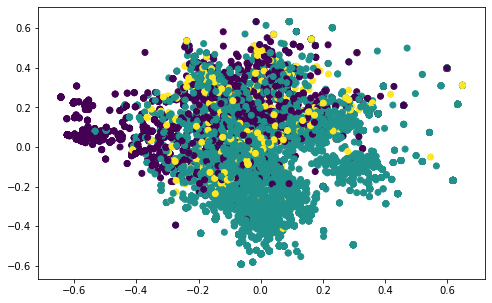

In [88]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

>### BoW

In [89]:
vectorizer = CountVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [90]:
%%time
decomposition = PCA(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 223 ms


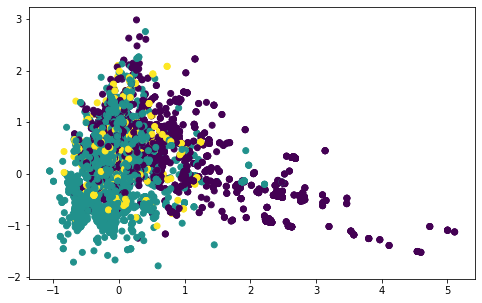

In [91]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

# Random Projection

>## Tfidf

In [92]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [93]:
%%time
decomposition = random_projection.SparseRandomProjection(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 73.1 ms


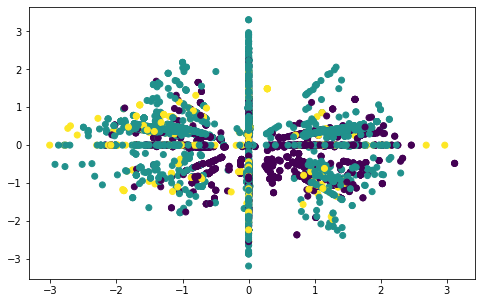

In [94]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

>## BoW

In [95]:
vectorizer = CountVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [96]:
%%time
decomposition = random_projection.SparseRandomProjection(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 93.1 ms


In [97]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

# UMAP

> ## Tfidf

In [98]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [99]:
%%time
decomposition = umap.UMAP(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 24.4 s


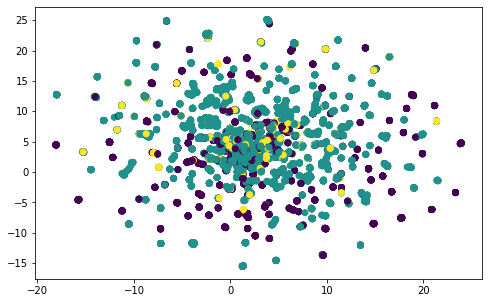

In [100]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

> ## BoW

In [101]:
vectorizer = CountVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [102]:
%%time
decomposition = umap.UMAP(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 25.1 s


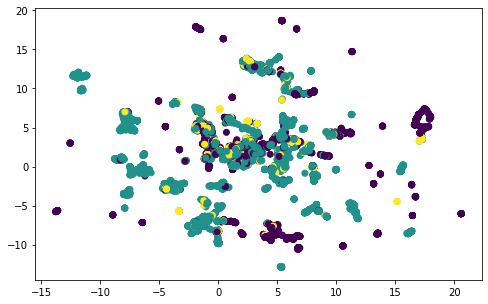

In [103]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

# Задание 5.1 на tkk datasets

## PCA

In [61]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_tkk(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

In [62]:
train_filename = "SentiRuEval_2016/tkk_train_2016.xml"
test_filename = "SentiRuEval_2016/tkk_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

In [63]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

>### Tfidf

In [64]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [65]:
%%time
decomposition = PCA(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 185 ms


In [66]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

>### BoW

In [67]:
vectorizer = CountVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [68]:
%%time
decomposition = PCA(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 186 ms


In [69]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

# Random Projection

>## Tfidf

In [70]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [71]:
%%time
decomposition = random_projection.SparseRandomProjection(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 44 ms


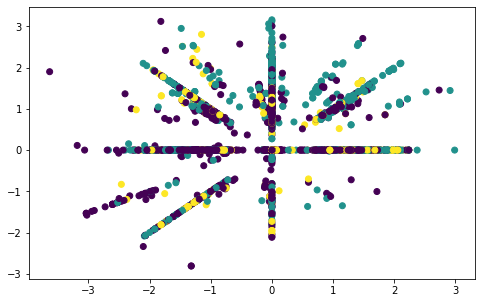

In [72]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

> ## BoW

In [73]:
vectorizer = CountVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [74]:
%%time
decomposition = random_projection.SparseRandomProjection(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 70 ms


In [75]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

# UMAP

> ## Tfidf

In [77]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [78]:
%%time
decomposition = umap.UMAP(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 1min 5s


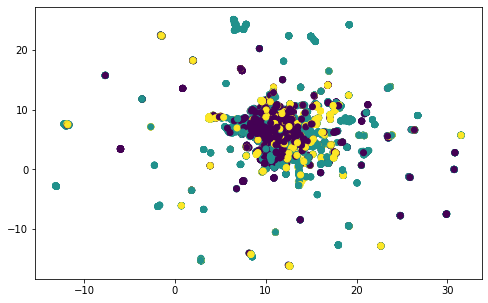

In [79]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

> ## BoW

In [80]:
vectorizer = CountVectorizer(max_features=100)
X = vectorizer.fit_transform(train['text'])

In [81]:
%%time
decomposition = umap.UMAP(n_components=2)
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 38.6 s


In [82]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()